In [ ]:
import pandas as pd
import numpy as np
import random
import ast
import os
import sys
import glob
sys.path.append('../')

from vcce.utils.cfe import cfe_utils
from vcce.utils.data import retrieve_test_patient
from vcce.visualize.vcce import VCCE

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
train_data_folder = os.path.join(parent_dir, 'data', 'processed')
info_folder = os.path.join(parent_dir, 'data', 'ptb-xl')
feature_set_folder = os.path.join(parent_dir, 'tests', 'ml_outcomes')

train = pd.read_csv(os.path.join(train_data_folder, 'train_ptbxl_extracted_features.csv'))
info = pd.read_csv(os.path.join(info_folder, 'ptbxl_database.csv'))
ml_results = pd.read_excel(os.path.join(feature_set_folder, 'results_rfe_xgb.xlsx'))

In [3]:
train.head()

RR_Prev  RR_Next   RR_Rate  PR_Int  PR_Seg   QRS  P_Wave  T_Wave  T_Left  \
0     0.88     0.70  0.795455    0.13    0.06  0.07    0.07    0.03    0.02   
1     0.70     0.71  1.014286    0.01    0.05  0.18    0.06    0.05    0.03   
2     0.71     0.70  0.985915    0.12    0.07  0.10    0.05    0.05    0.03   
3     0.70     0.71  1.014286    0.14    0.10  0.12    0.04    0.03    0.01   
4     0.71     0.70  0.985915    0.10    0.05  0.11    0.05    0.04    0.02   

     QT  ...  V6_ST_std   Age  Gender  Patient_id  Label  Beat_P_idx  \
0  0.16  ...   0.053389  52.0     1.0      1942.0   NORM         106   
1  0.29  ...   0.051606  52.0     1.0      1942.0   NORM         176   
2  0.29  ...   0.049602  52.0     1.0      1942.0   NORM         247   
3  0.21  ...   0.035149  52.0     1.0      1942.0   NORM         315   
4  0.31  ...   0.062674  52.0     1.0      1942.0   NORM         389   

   Beat_Q_idx  Beat_R_idx  Beat_S_idx  Beat_T_idx  
0         118         121         125         131  
1         188         191         196         203  
2         259         262         265         284  
3         329         332         336         346  
4         399         403         407         426  

[5 rows x 203 columns]

In [4]:
info.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

In [5]:
def condition_func(row, condition):
    scp_codes = ast.literal_eval(row['scp_codes'])
    return (
        condition in scp_codes 
        and scp_codes.get(condition, 0) == 100.0 
        and 'STTC' not in scp_codes
    )

def find_ids(info):
    anterior_patients = info[info.apply(condition_func, condition='AMI', axis=1)]
    inferior_patients = info[info.apply(condition_func, condition='IMI', axis=1)]
    norm_patients = info[info.apply(condition_func, condition='NORM', axis=1)]
    return anterior_patients, inferior_patients, norm_patients

In [6]:
duplicates = info[info.duplicated(subset='patient_id', keep=False)]

unique_patients = info[~info['patient_id'].isin(duplicates['patient_id'])]

anterior_patients, inferior_patients, norm_patients = find_ids(unique_patients)

In [7]:
random.seed(42)

def get_random_patients(train, patients_df, num_samples=1):
    common_patient_ids = set(train["Patient_id"]).intersection(set(patients_df['patient_id']))
    return random.sample(list(common_patient_ids), num_samples)

def save_sets_to_excel(train, patient_ids, file_name):
    set_ = train[train["Patient_id"].isin(patient_ids)]
    dir = os.path.dirname(file_name)  # Get the directory part of the path
    os.makedirs(dir, exist_ok=True)
    set_.to_excel(file_name, index=False)
    return set_

random_inf_patients = get_random_patients(train, inferior_patients)
random_ant_patients = get_random_patients(train, anterior_patients)
random_norm_patients = get_random_patients(train, norm_patients)

inf_set = save_sets_to_excel(train, random_inf_patients, "../tests/sets/imi_set.xlsx")
ant_set = save_sets_to_excel(train, random_ant_patients, "../tests/sets/ami_set.xlsx")
norm_set = save_sets_to_excel(train, random_norm_patients, "../tests/sets/norm_set.xlsx")

In [8]:
inf_df = pd.DataFrame(random_inf_patients)
ant_df = pd.DataFrame(random_ant_patients)
norm_df = pd.DataFrame(random_norm_patients)

inf_df.to_excel("../tests/sets/imi_patient.xlsx", index=False)
ant_df.to_excel("../tests/sets/ami_patient.xlsx", index=False)
norm_df.to_excel("../tests/sets/norm_patient.xlsx", index=False)

In [9]:
inf_set

RR_Prev  RR_Next   RR_Rate  PR_Int  PR_Seg   QRS  P_Wave  T_Wave  \
27024     1.18     1.03  0.872881    0.18    0.12  0.12    0.06    0.10   
27025     1.03     1.04  1.009709    0.19    0.11  0.09    0.08    0.06   
27026     1.04     1.02  0.980769    0.18    0.14  0.11    0.04    0.07   
27027     1.02     1.05  1.029412    0.10    0.04  0.14    0.06    0.07   
27028     1.05     1.04  0.990476    0.19    0.15  0.10    0.04    0.12   
27029     1.04     1.03  0.990385    0.12    0.09  0.14    0.03    0.09   
27030     1.03     1.04  1.009709    0.12    0.02  0.18    0.10    0.09   

       T_Left    QT  ...  V6_ST_std   Age  Gender  Patient_id  Label  \
27024    0.06  0.25  ...   0.014347  75.0     0.0      9830.0     MI   
27025    0.04  0.19  ...   0.017162  75.0     0.0      9830.0     MI   
27026    0.05  0.21  ...   0.018380  75.0     0.0      9830.0     MI   
27027    0.05  0.25  ...   0.029874  75.0     0.0      9830.0     MI   
27028    0.06  0.24  ...   0.006980  75.0     0.0      9830.0     MI   
27029    0.06  0.26  ...   0.007771  75.0     0.0      9830.0     MI   
27030    0.06  0.30  ...   0.004782  75.0     0.0      9830.0     MI   

       Beat_P_idx  Beat_Q_idx  Beat_R_idx  Beat_S_idx  Beat_T_idx  
27024         176         192         198         201         211  
27025         283         298         301         304         313  
27026         383         401         405         408         418  
27027         490         499         507         509         520  
27028         590         608         612         614         625  
27029         696         708         716         718         729  
27030         799         815         819         821         832  

[7 rows x 203 columns]

In [10]:
def process_patients(train, patients, set_, target, src, dest, sublabel, features):
    for patient in patients:
        
        filtered_patient = set_[set_["Patient_id"] == int(patient)]
        r_peaks = filtered_patient["Beat_R_idx"]
        filtered_patient.set_index(r_peaks, inplace=True)
        data = train[features + ["Label"]]
        filtered_patient = filtered_patient[features + [target]]

        path = f"../tests/counterfactuals/{src}/{patient}_{sublabel}"

        c = cfe_utils(train=data, test=filtered_patient, target=target, src=src, dest=dest, path=path)
        exp = c.get_dice_trained_model()

        c.get_counterfactuals(exp=exp, cfe_count=5)
        c.json_to_excel()
        
        column_string = " ".join(features)
        c.find_change_count_in_excel(cfe_count=5, column_list=c.get_column_list(column_string))
        
        del c

## Extracting counterfactual clues

In [ ]:
train = pd.read_csv(os.path.join(train_data_folder, 'train_ptbxl_extracted_features.csv'))
ml_results = pd.read_excel(os.path.join(feature_set_folder, 'results_rfe_xgb.xlsx'))

datasets_info = [
    {"patients_df": random_inf_patients, "file_name": "../tests/sets/imi_set.xlsx", "src": "MI", 'sublabel': 'IMI', 'dest': 'NORM'},
    {"patients_df": random_ant_patients, "file_name": "../tests/sets/ami_set.xlsx", "src": "MI", 'sublabel': 'AMI', 'dest': 'NORM'},
    {"patients_df": random_norm_patients, "file_name": "../tests/sets/norm_set.xlsx", "src": "NORM", 'sublabel': 'NORM', 'dest': 'MI'}
]

target = "Label"
first_20_features = ml_results["Feature Names"].head(20).tolist()
first_20_and_expert_features = first_20_features + ["V2_T", "V3_T", "V4_T", "V6_T"]

for info in datasets_info:
    set_ = pd.read_excel(info["file_name"])
    process_patients(train=train, patients=info["patients_df"], set_=set_, target=target,
                     src=info["src"], dest=info["dest"], sublabel=info["sublabel"], features= first_20_and_expert_features)


______

## Visualization

In [13]:
def get_patient_ids(base_path, y, sublabel):
    patient_folder_path = os.path.join(base_path, y)
    folders = glob.glob(os.path.join(patient_folder_path, f"*_{sublabel}"))
    return [os.path.basename(folder).split('_')[0] for folder in folders]

def process_patient(sublabel, patient_id, y, x, base_path, dataset_path, set_folder_path, save_path):
    retrieve_test_patient(dataset_path, float(patient_id), save_path)
    
    set_file = os.path.join(set_folder_path, f"{sublabel.lower()}_set.xlsx")
    test = pd.read_excel(set_file)
    features = test[test["Patient_id"] == float(patient_id)]

    signal_file = os.path.join(save_path, f"{patient_id}_{y}/signal.npy")
    signal = np.load(signal_file)

    counterfactuals_file = os.path.join(base_path, f"{y}/{patient_id}_{sublabel}/feature_changes/{y}/{x}_feature_changes.xlsx")
    counterfactuals = pd.read_excel(counterfactuals_file)
    
    v = VCCE(signal=signal, extracted_features=features, counterfactuals=counterfactuals, feature_count=24)
    
    #v.create_visualization_graph(show_graph=True)
    v.plot_ecg_report(signal=signal, 
                      sampling_rate=100,
                      method="koka2022",
                      show_peaks=False, 
                      show_advanced=True,
                      show_emphasis=True, 
                      fig_size=(32, 48), 
                      fig_col=1, save=True, 
                      save_path=save_path,
                      save_format='pdf', 
                      file_name=f'{patient_id}_report')

### Note

Following collaborative work with the doctors, we enhanced these results by incorporating four additional signal features (`V2_T, V3_T, V4_T, V6_T`). The outcomes demonstrated improvement and increased significance, especially in individual cases.

Note: Selected index is NORM patient, and the patient info is [Age: 61.0, Gender: 0.0, Patient ID: 16773.0]: 
The extracted patients are saved in the following directory:
          ../tests/visualizations/16773.0_NORM



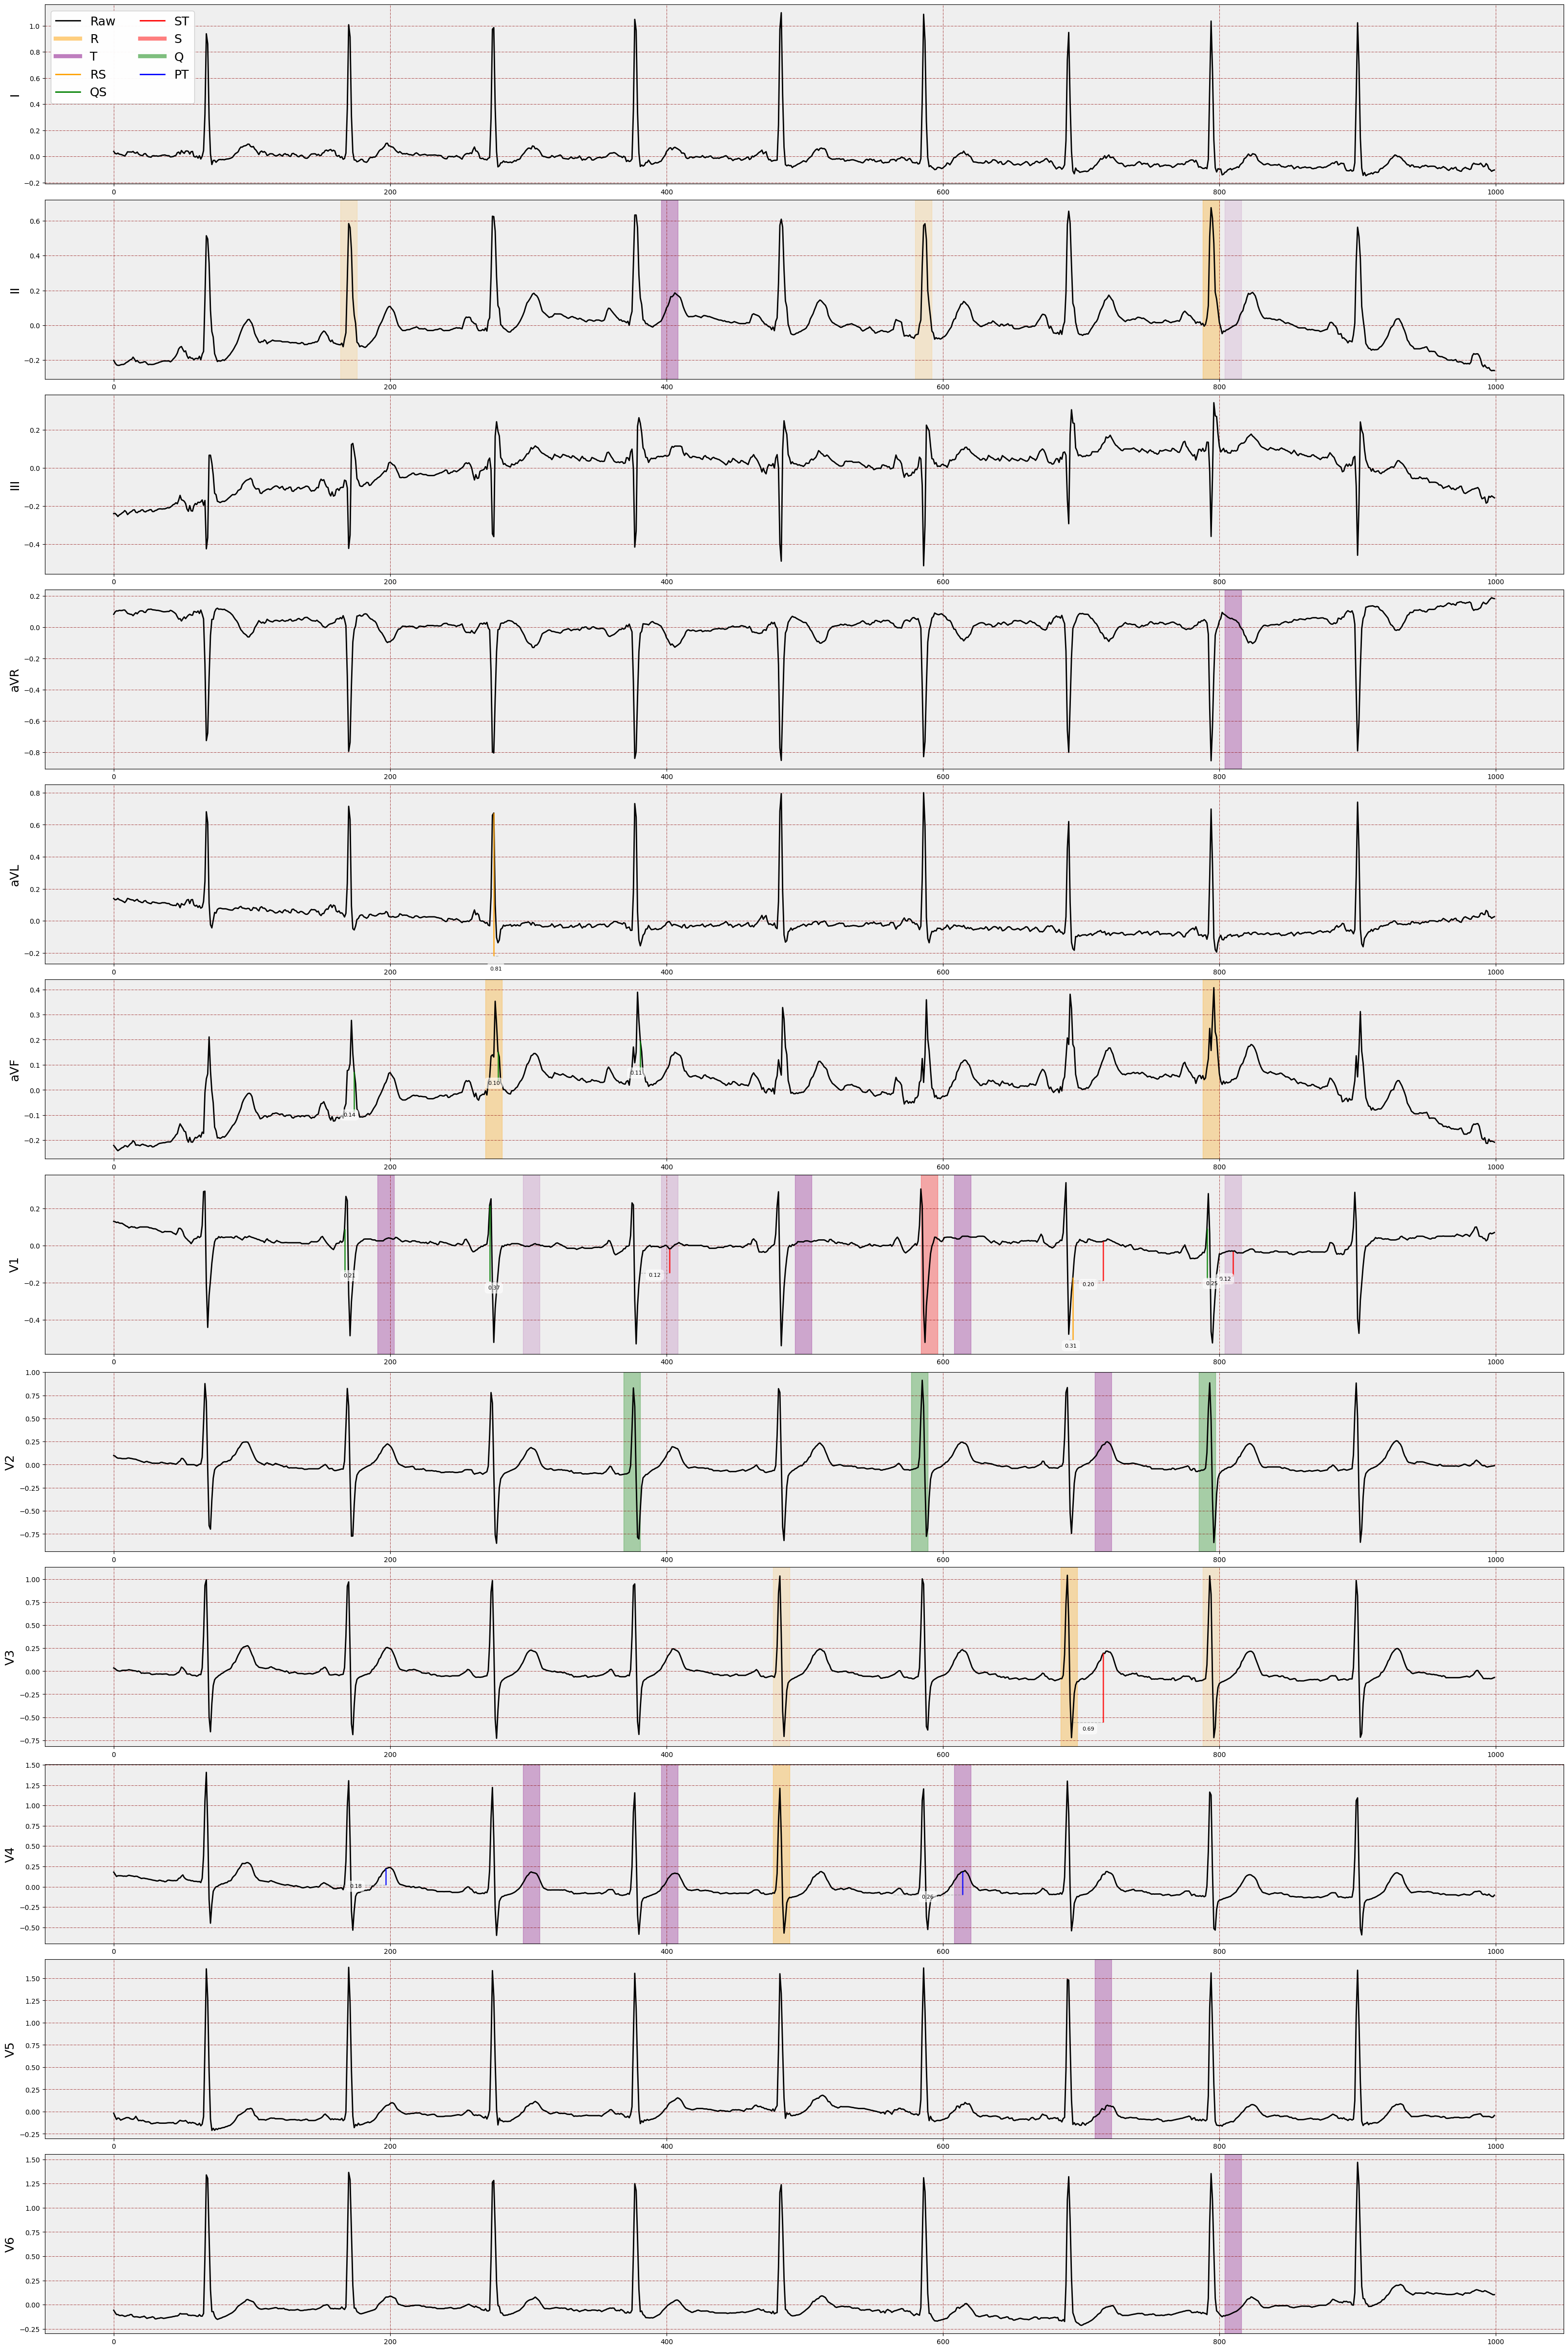

Note: Selected index is MI patient, and the patient info is [Age: 75.0, Gender: 0.0, Patient ID: 9830.0]: 
The extracted patients are saved in the following directory:
          ../tests/visualizations/9830.0_MI



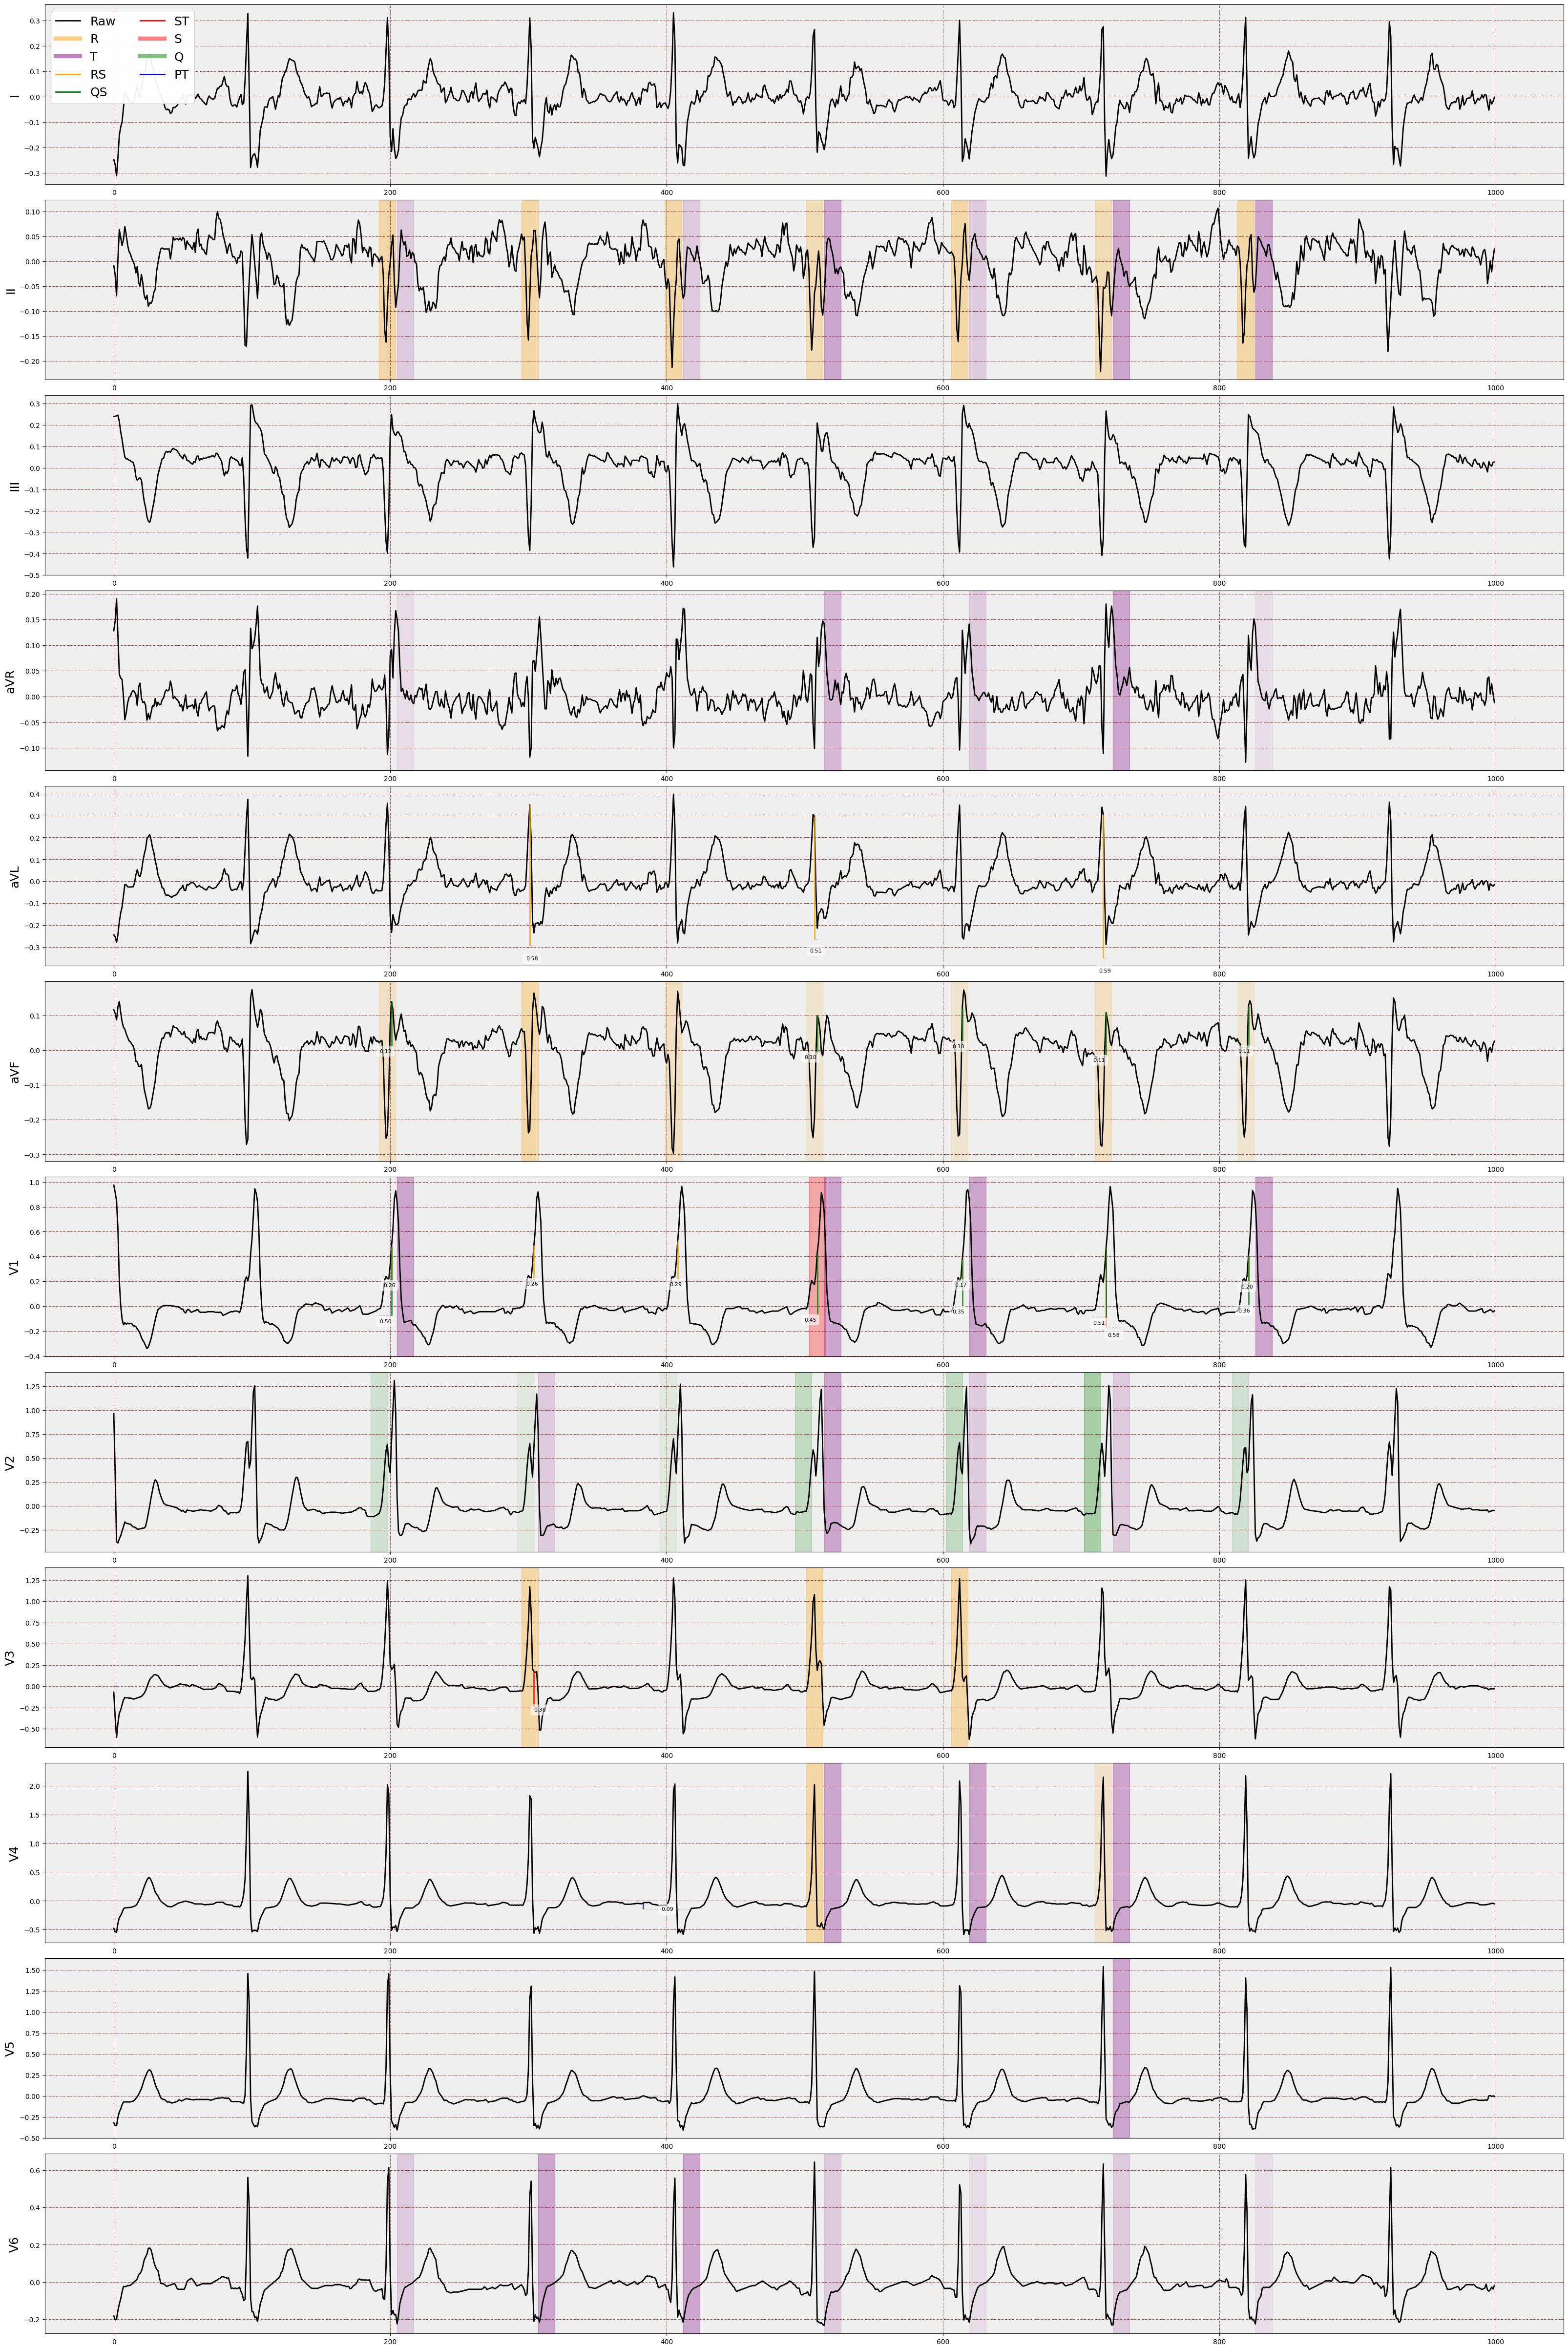

Note: Selected index is MI patient, and the patient info is [Age: 74.0, Gender: 0.0, Patient ID: 3234.0]: 
The extracted patients are saved in the following directory:
          ../tests/visualizations/3234.0_MI



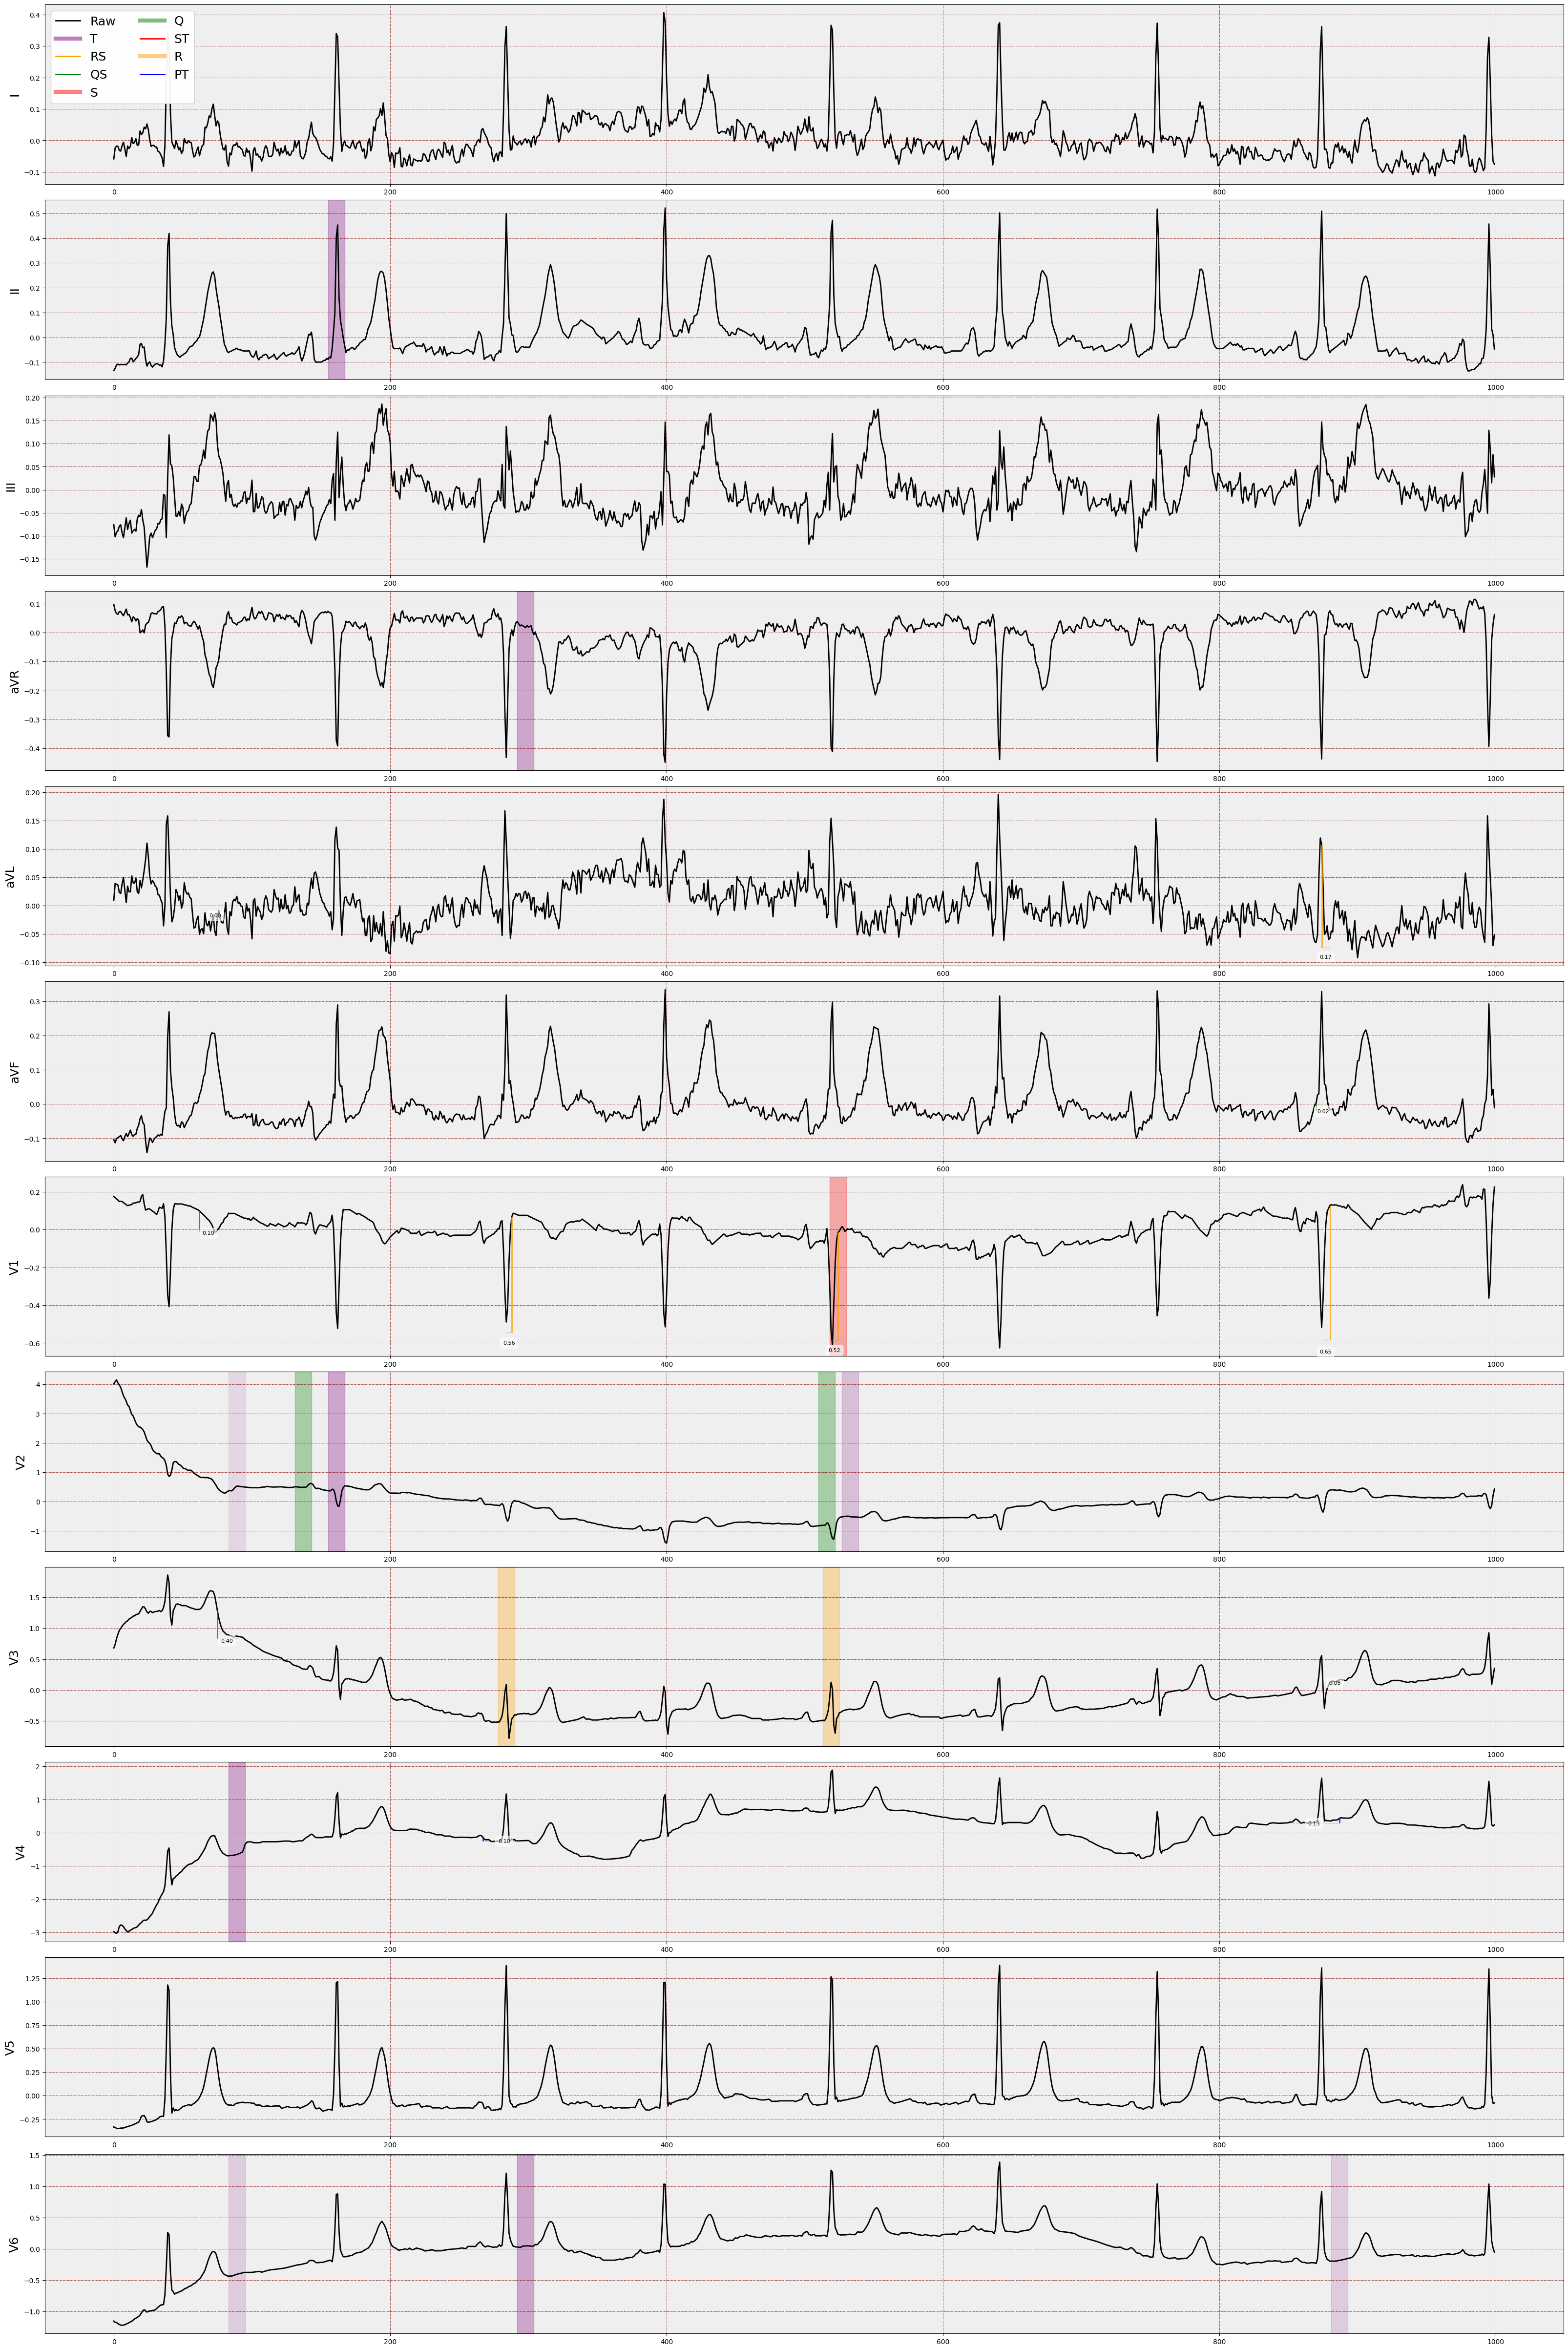

In [14]:
base_path = '../tests/counterfactuals'
dataset_path = '../data/extracted_data'
output_dir = '../tests/visualizations'
set_folder_path = '../tests/sets'

folders_info = [
    {'sublabel':'NORM', 'x': 'NORM_to_MI', 'y': 'NORM'},
    {'sublabel':'IMI', 'x': 'MI_to_NORM', 'y': 'MI'},
    {'sublabel':'AMI', 'x': 'MI_to_NORM', 'y': 'MI'}
]

for info in folders_info:
    patient_ids = get_patient_ids(base_path, info['y'], info['sublabel'])
    for patient_id in patient_ids:
        process_patient(info['sublabel'], patient_id, info['y'], info['x'], base_path, dataset_path, set_folder_path, output_dir)
